## Data uploading and cleaning

In [2]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("data_for_Assignment1.csv")

In [ ]:
#data.info(verbose = True)

In [4]:
data[["city", "country"]]= data["host_location"].str.split(',', expand = True)

In [5]:
data = data.loc[:, ['id', 'price',
       'host_is_superhost', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'city']]

In [9]:
data.describe()

,id,price,latitude,longitude,accommodates,availability_365,number_of_reviews,review_scores_rating
count,4.661000e+03,4661.000000,4661.000000,4661.000000,4661.000000,4661.000000,4661.000000,3881.000000
mean,4.528751e+17,138.029393,48.139628,11.565164,2.734177,103.191161,31.075091,4.819673
std,4.688564e+17,1426.151397,0.025586,0.046706,1.569399,115.925872,83.081440,0.275215
min,9.794500e+04,0.000000,48.072350,11.390700,1.000000,0.000000,0.000000,1.000000
25%,2.851660e+07,0.000000,48.122180,11.539880,2.000000,0.000000,1.000000,4.750000
50%,5.490000e+17,80.000000,48.136810,11.565378,2.000000,56.000000,7.000000,4.910000
75%,9.390000e+17,150.000000,48.156296,11.587030,4.000000,184.000000,24.000000,5.000000
max,1.190000e+18,96274.000000,48.224071,11.712699,16.000000,365.000000,1874.000000,5.000000


In [7]:
# we have to tidy data up by dropping all cities behind Munich because this is our investigation area. Furthermore, we
# should change data type of "host_acceptance_rate" variable to use it as numeric one. Finally, it might be more representative 
# to replace letter abbreviation for numeric categorical levels of "host_is_superhost" and "instant_bookable" variables. 

data = data[data["city"] == "Munich"]
data["host_is_superhost"] = np.where(data["host_is_superhost"] == "f", 0, np.where(data["host_is_superhost"] == "t", 1, data["host_is_superhost"]))
data["instant_bookable"] = np.where(data["instant_bookable"] == "f", 0, np.where(data["instant_bookable"] == "t", 1, data["instant_bookable"]))

In [10]:
# Now lets draw our attention on property_type and room_type variables. If we output summarize by number of categories included
# in the former variables, we figure out that it consists of 47 different levels. This case is quite difficult for interpretation
# within using it in regression model.
(
     data.melt(id_vars = "property_type", value_vars = "price").groupby(["property_type", "variable"]).agg("count").round(2).head()
)

,,value
property_type,variable,
Camper/RV,price,5
Entire bungalow,price,1
Entire cabin,price,1
Entire chalet,price,1
Entire condo,price,269


In [11]:
# In turn, describing room_type, we see it includes 4 levels. However, their count destributions differs a lot. 
# The reasonable step would be to get rid out of Hotel room and Shared room levels and keep only Entire home/apt and
# Private room because they contain the main data massive. 
(
     data.melt(id_vars = "room_type", value_vars = "price").groupby(["room_type", "variable"]).agg(["mean", "std", "min", "max", "count"]).round(2)
)

value                           
                             mean       std min    max count
room_type       variable                                    
Entire home/apt price      139.99    264.49   0  11000  2980
Hotel room      price      175.17    248.84   0    700    23
Private room    price       73.29     97.26   0    999  1623
Shared room     price     2948.77  16242.24   0  96274    35

In [12]:
data = data[data["room_type"].isin(["Entire home/apt", "Private room"])]

In [13]:
(
     data.melt(id_vars = "room_type", value_vars = "price").groupby(["room_type", "variable"]).agg(["mean", "std", "min", "max", "count"]).round(2)
)

value                         
                            mean     std min    max count
room_type       variable                                 
Entire home/apt price     139.99  264.49   0  11000  2980
Private room    price      73.29   97.26   0    999  1623

In [51]:
#data["room_type"] = np.where(data["room_type"] == "Entire home/apt", 0, np.where(data["room_type"] == "Private room", 1, data["room_type"]))

#data = data.drop("property_type", axis=1)

In [14]:
# let's also add new variable of log(price) and get rid of zero price in our database. The key point of this modification is
# to compresse data to get smoothed outliers.

data = data[data['price'] > 0]
data["log_price"] = np.log(data["price"])

In [15]:
# After a preliminary variable selection we are also interested in NA
data.isna().sum().sum()

536

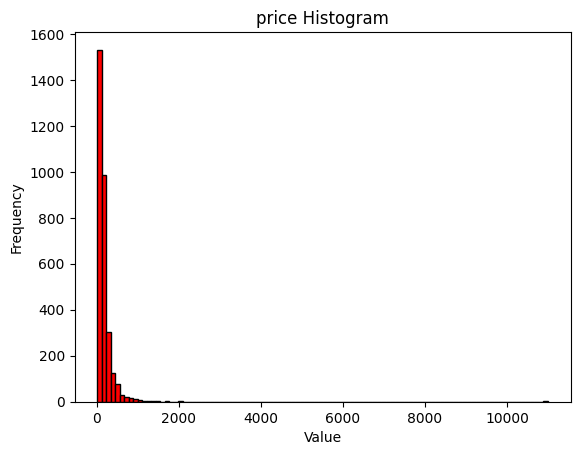

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(data['price'], bins=100, color='red', edgecolor='black')
plt.title('price Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

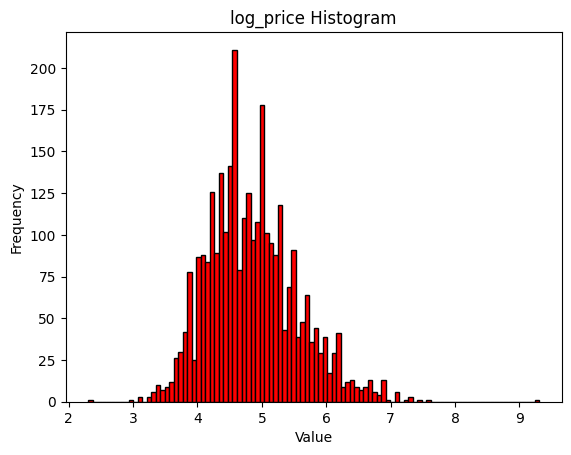

In [55]:
plt.hist(data['log_price'], bins=100, color='red', edgecolor='black')
plt.title('log_price Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

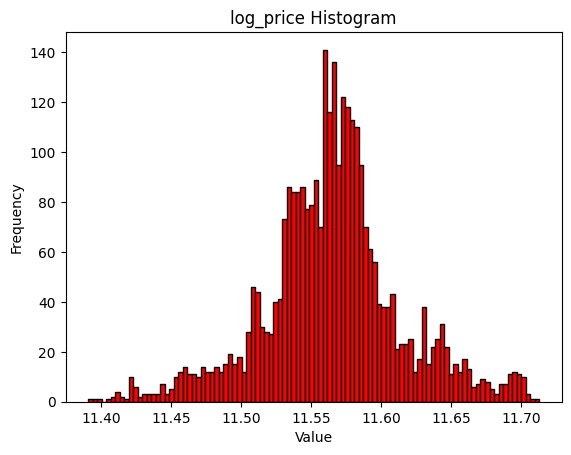

In [56]:
plt.hist(data['longitude'], bins=100, color='red', edgecolor='black')
plt.title('log_price Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Descriptive statistics

In [17]:
# Basically, the reason of such great number of missing values is based on 2 variables host_acceptance_rate and review_scores_rating.
# Initially we are not going to use them in our regression models, so for the sake of accuracy we keep 4603 observations for now. 
# Before using these variables in model, we will totally clean the data up.  
data.describe()

,id,price,latitude,longitude,accommodates,availability_365,number_of_reviews,review_scores_rating,log_price
count,3.115000e+03,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,2605.000000,3115.000000
mean,5.175201e+17,172.108828,48.139157,11.564677,2.760835,143.216693,37.333868,4.817159,4.855254
std,4.801601e+17,252.533133,0.026258,0.049112,1.584367,112.481188,89.655923,0.277073,0.700444
min,9.794500e+04,10.000000,48.072350,11.390700,1.000000,0.000000,0.000000,1.000000,2.302585
25%,2.859023e+07,79.000000,48.121081,11.538326,2.000000,43.500000,2.000000,4.740000,4.369448
50%,6.780000e+17,120.000000,48.136620,11.565020,2.000000,113.000000,8.000000,4.900000,4.787492
75%,9.710000e+17,195.000000,48.156370,11.587500,4.000000,236.000000,31.000000,5.000000,5.273000
max,1.190000e+18,11000.000000,48.224071,11.712699,16.000000,365.000000,1412.000000,5.000000,9.305651


In [18]:
data.dtypes

id                      float64
price                     int64
host_is_superhost        object
latitude                float64
longitude               float64
property_type            object
room_type                object
accommodates              int64
availability_365          int64
number_of_reviews         int64
review_scores_rating    float64
instant_bookable         object
city                     object
log_price               float64
dtype: object

In [59]:
data['instant_bookable'] = data['instant_bookable'].astype(int)

In [60]:
list_var = ['id', 'price', 'log_price',
        'latitude', 'longitude', 'room_type',
       'accommodates', 'availability_365', 'number_of_reviews', 'instant_bookable', 'city', 'review_scores_rating']

from skimpy import skim

skim(data.filter(list_var))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3115   │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 12     │ │ int32       │ 5     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_n ┃     ┃       ┃           ┃          ┃       ┃          ┃          ┃          ┃          ┃        ┃  │
│ ┃ ame      ┃ NA  ┃ NA %  ┃ mean      ┃ sd       ┃ p0    ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ id       │   0 │     0 │ 5.175e+17 │ 4.802e+1 │ 97940 │ 28590000 │ 6.78e+17 │ 9.71e+17 │ 1.19e+18 │ ▇  ▃▃▃ │  │
│ │          │     │       │           │        7 │       │          │          │          │          │        │  │
│ │ price    │   0 │     0 │     172.1 │    252.5 │    10 │       79 │      120 │      195 │    11000 │   ▇    │  │
│ │ log_pric │   0 │     0 │     4.855 │   0.7004 │ 2.303 │    4.369 │    4.787 │    5.273 │    9.306 │   ▇▇▂  │  │
│ │ e        │     │       │           │          │       │          │          │          │          │        │  │
│ │ latitude │   0 │     0 │     48.14 │  0.02626 │ 48.07 │    48.12 │    48.14 │    48.16 │    48.22 │ ▁▅▇▅▂  │  │
│ │ longitud │   0 │     0 │     11.56 │  0.04911 │ 11.39 │    11.54 │    11.57 │    11.59 │    11.71 │  ▁▅▇▂▁ │  │
│ │ e        │     │       │           │          │       │          │          │          │          │        │  │
│ │ accommod │   0 │     0 │     2.761 │    1.584 │     1 │        2 │        2 │        4 │       16 │  ▇▂▁   │  │
│ │ ates     │     │       │           │          │       │          │          │          │          │        │  │
│ │ availabi │   0 │     0 │     143.2 │    112.5 │     0 │     43.5 │      113 │      236 │      365 │ ▇▅▃▃▃▃ │  │
│ │ lity_365 │     │       │           │          │       │          │          │          │          │        │  │
│ │ number_o │   0 │     0 │     37.33 │    89.66 │     0 │        2 │        8 │       31 │     1412 │   ▇    │  │
│ │ f_review │     │       │           │          │       │          │          │          │          │        │  │
│ │ s        │     │       │           │          │       │          │          │          │          │        │  │
│ │ instant_ │   0 │     0 │    0.1409 │    0.348 │     0 │        0 │        0 │        0 │        1 │ ▇    ▁ │  │
│ │ bookable │     │       │           │          │       │          │          │          │          │        │  │
│ │ review_s │ 510 │ 16.37 │     4.817 │   0.2771 │     1 │     4.74 │      4.9 │        5 │        5 │      ▇ │  │
│ │ cores_ra │     │       │           │          │       │          │          │          │          │        │  │
│ │ ting     │     │       │           │          │       │          │          │          │          │        │  │
│ └──────────┴─────┴───────┴───────────┴──────────┴─────

In [21]:
# we also need to modify our object variables to integer but firstly NA tidy up must be accomplished.
# As it's said before we'd firstly like to build some simple models without variables that include NA
# Anyway, let's keep below code in mind 

#data['host_is_superhost '] = data['host_is_superhost'].astype(int)
#data['room_type'] = data['room_type'].astype(int)

## Plots

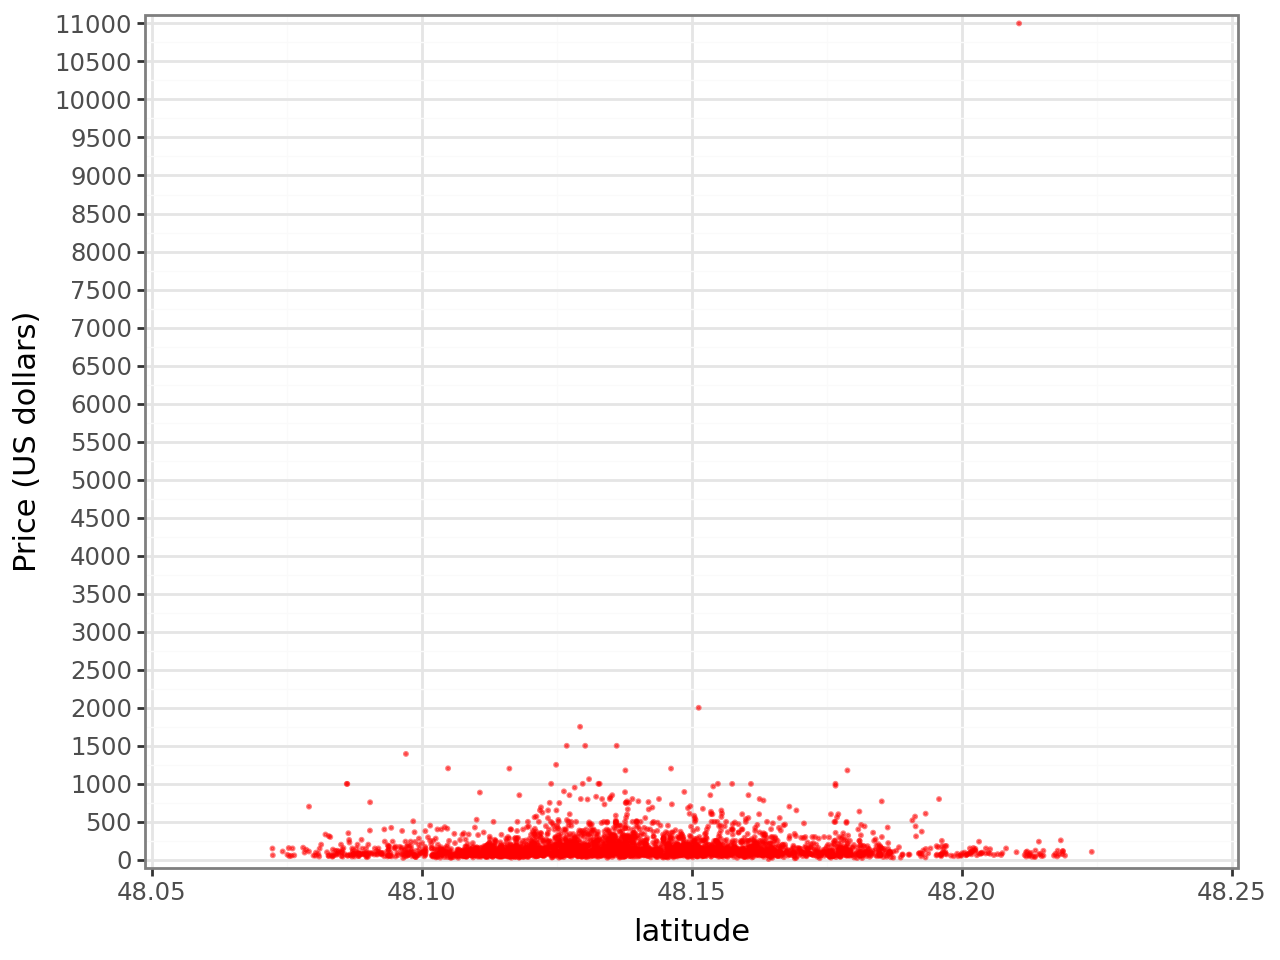

In [61]:
# In the plot we observe one knockout outlier that really disturbs. As a solution we can drop it by filtering our data
# or take a logarithm. The second option will be later.

plot = (
    ggplot(data=data)
    + geom_point(aes(x = "latitude", y = "price"), color="red", size = 0.2, alpha = 0.5)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.001, 0.001), limits=(48.05, 48.25))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 11000), breaks=np.arange(0, 11001, 500)
    )
    + labs(x="latitude", y="Price (US dollars)")
    + theme_bw()
)
plot

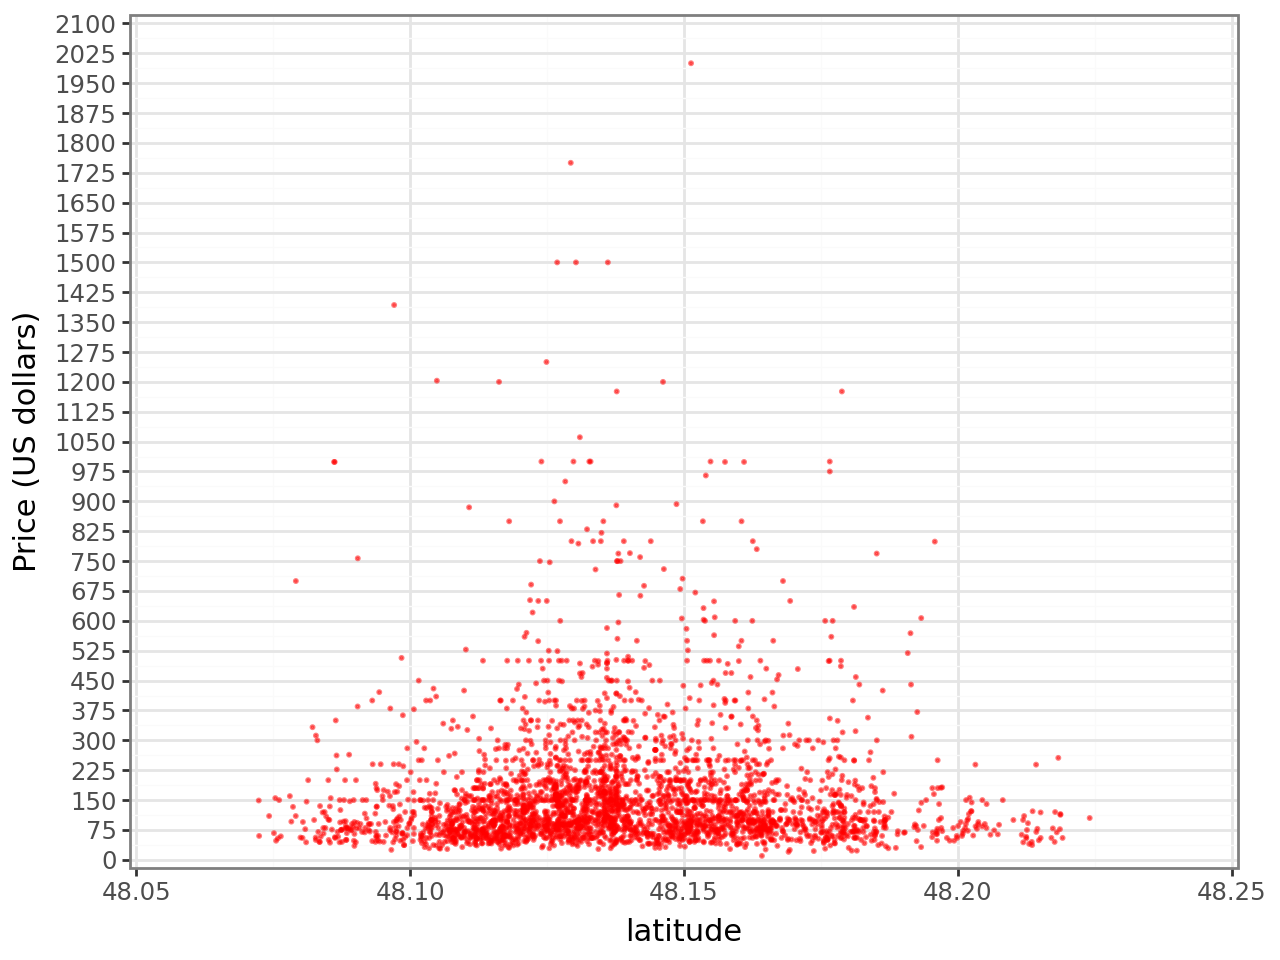

In [62]:
# The sketch looks much better but there is no visible pattern
plot = (
    ggplot(data=data)
    + geom_point(aes(x = "latitude", y = "price"), color="red", size = 0.2, alpha = 0.5)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.001, 0.001), limits=(48.05, 48.25))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 2100), breaks=np.arange(0, 2101, 75)
    )
    + labs(x="latitude", y="Price (US dollars)")
    + theme_bw()
)
plot

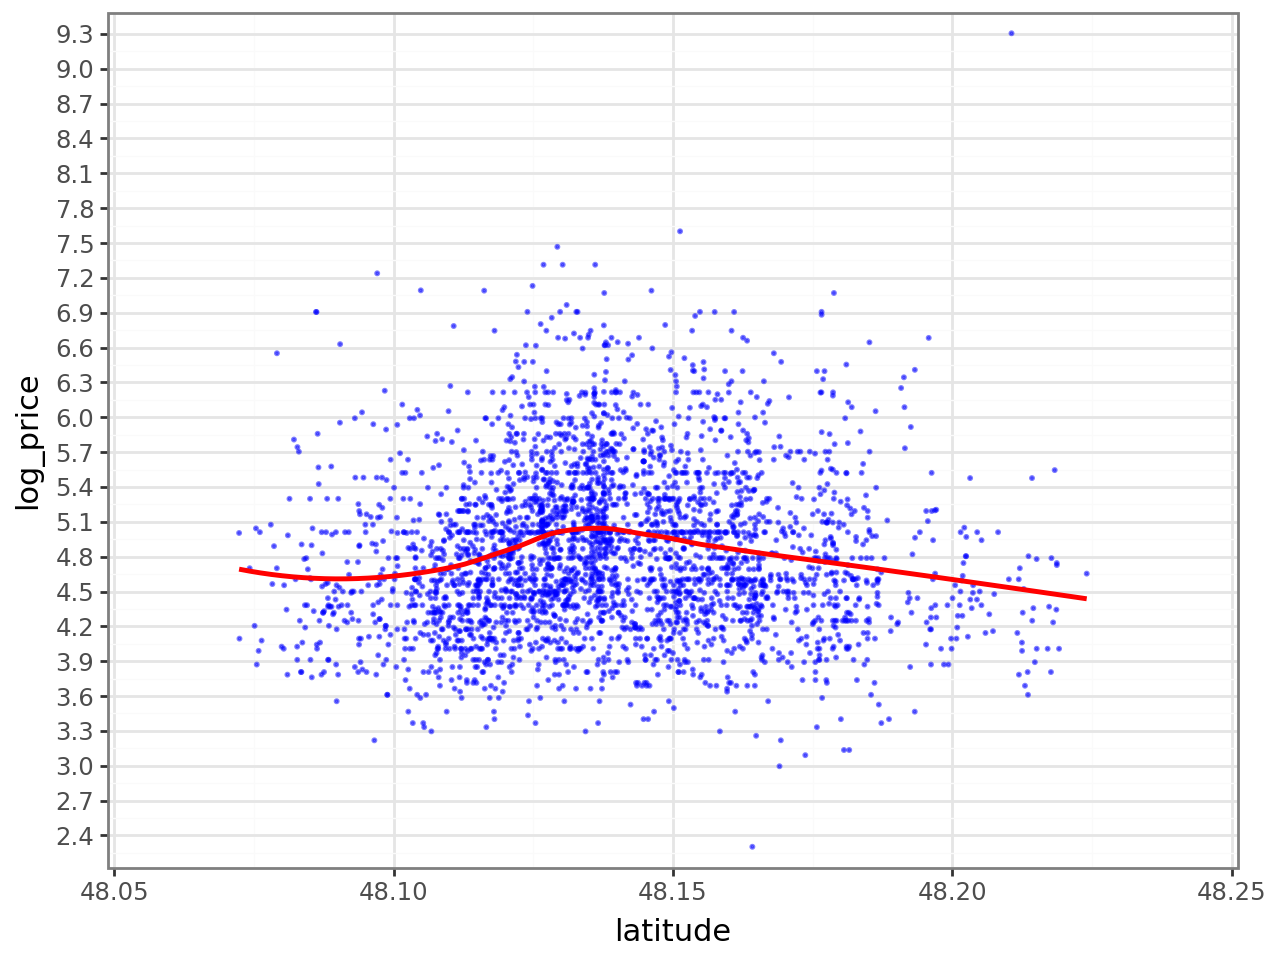

In [63]:
# let's use log_price and add loess method. 
# Here we see a clear non-linear data behavior

plot = (
    ggplot(data=data)
    + geom_point(aes(x = "latitude", y = "log_price"), color="blue", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x='latitude', y='log_price'), method="loess", color='red', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.001, 0.001), limits=(48.05, 48.25))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.2, 9.4), breaks=np.arange(0, 9.5, 0.3)
    )
    + labs(x="latitude", y="log_price")
    + theme_bw()
)
plot

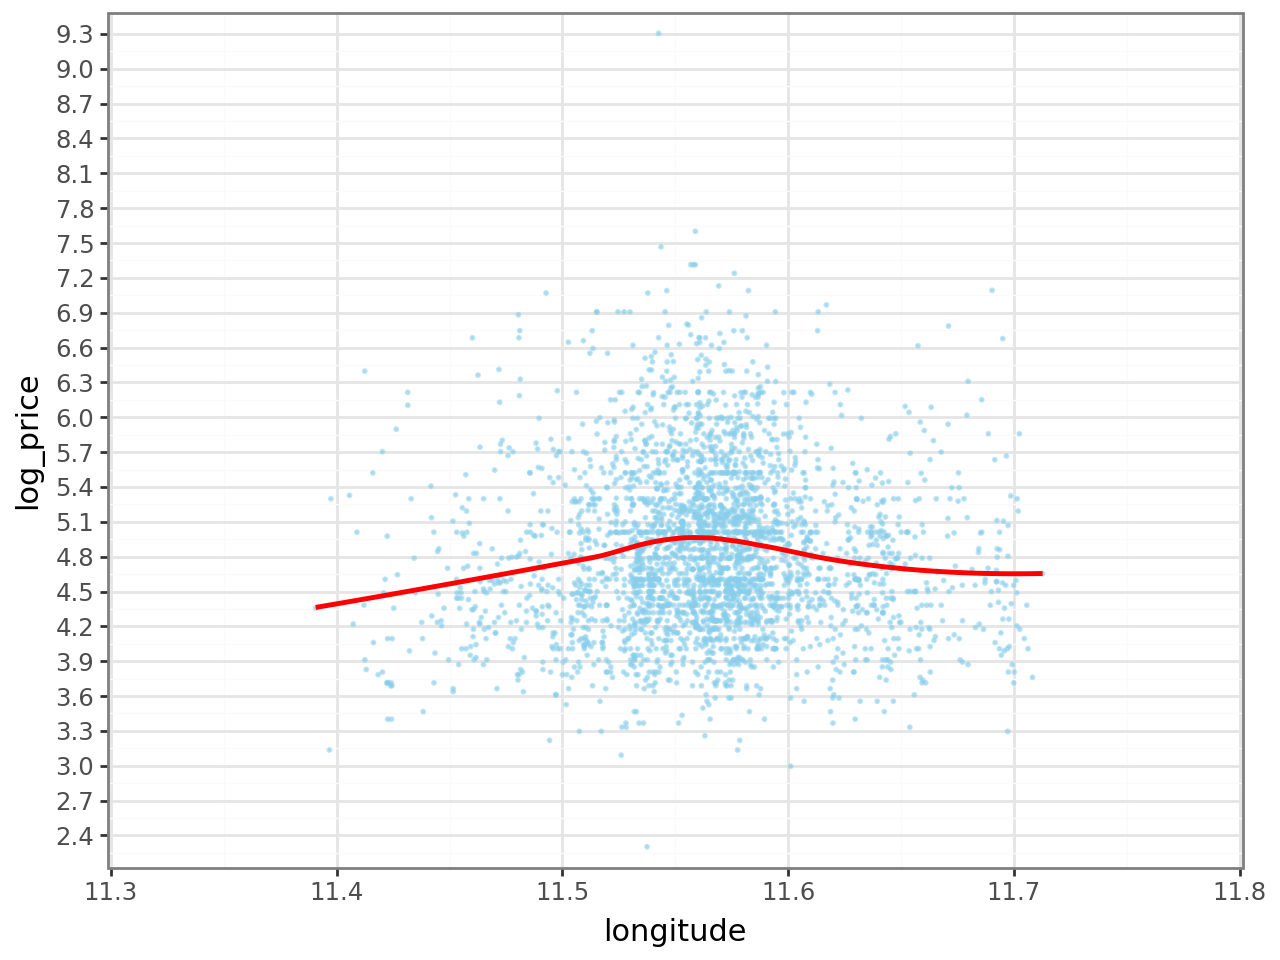

In [68]:
# let's do the same for longitude variable

plot = (
    ggplot(data=data)
    + geom_point(aes(x = "longitude", y = "log_price"), color="skyblue", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x='longitude', y='log_price'), method="loess", color='red', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.001, 0.001), limits=(11.3, 11.8))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.2, 9.4), breaks=np.arange(0, 9.5, 0.3)
    )
    + labs(x="longitude", y="log_price")
    + theme_bw()
)
plot.save("longitude.png")
plot

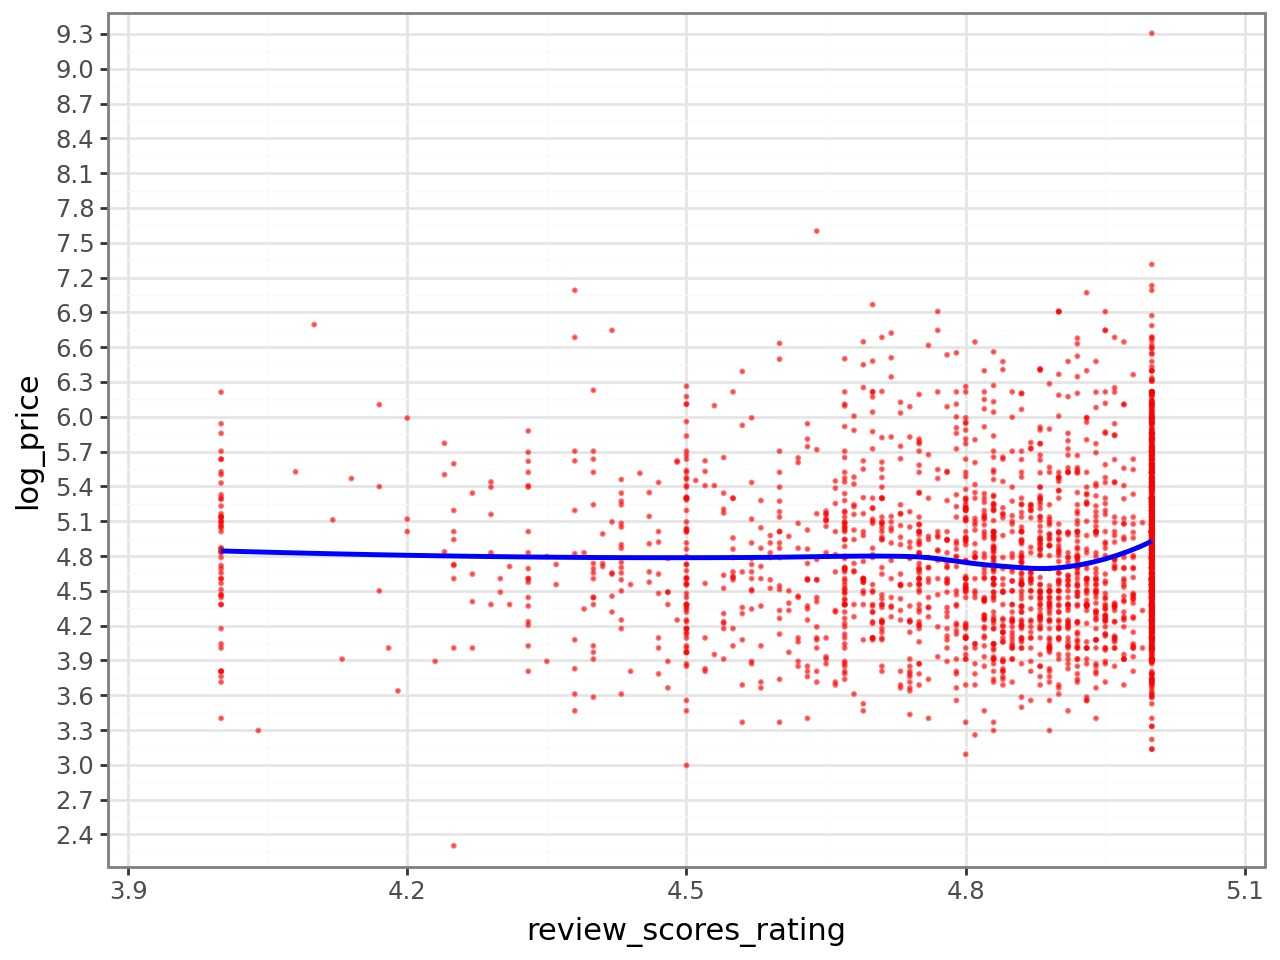

In [26]:
# let's cut it off
plot = (
    ggplot(data=data)
    + geom_point(aes(x = "review_scores_rating", y = "log_price"), color="red", size = 0.2, alpha = 0.5)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(3.9, 5.1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.2, 9.4), breaks=np.arange(0, 9.5, 0.3)
    )
    + geom_smooth(aes(x = "review_scores_rating", y = "log_price"), color="blue", method="loess", se=False)
    + labs(x="review_scores_rating", y="log_price")
    + theme_bw()
)
plot 

In [27]:
#(
#     data.melt(id_vars = "accommodates", value_vars = "price").groupby(["accommodates", "variable"]).agg(["mean", "std", "min", "max", "count"]).round(2)
#)

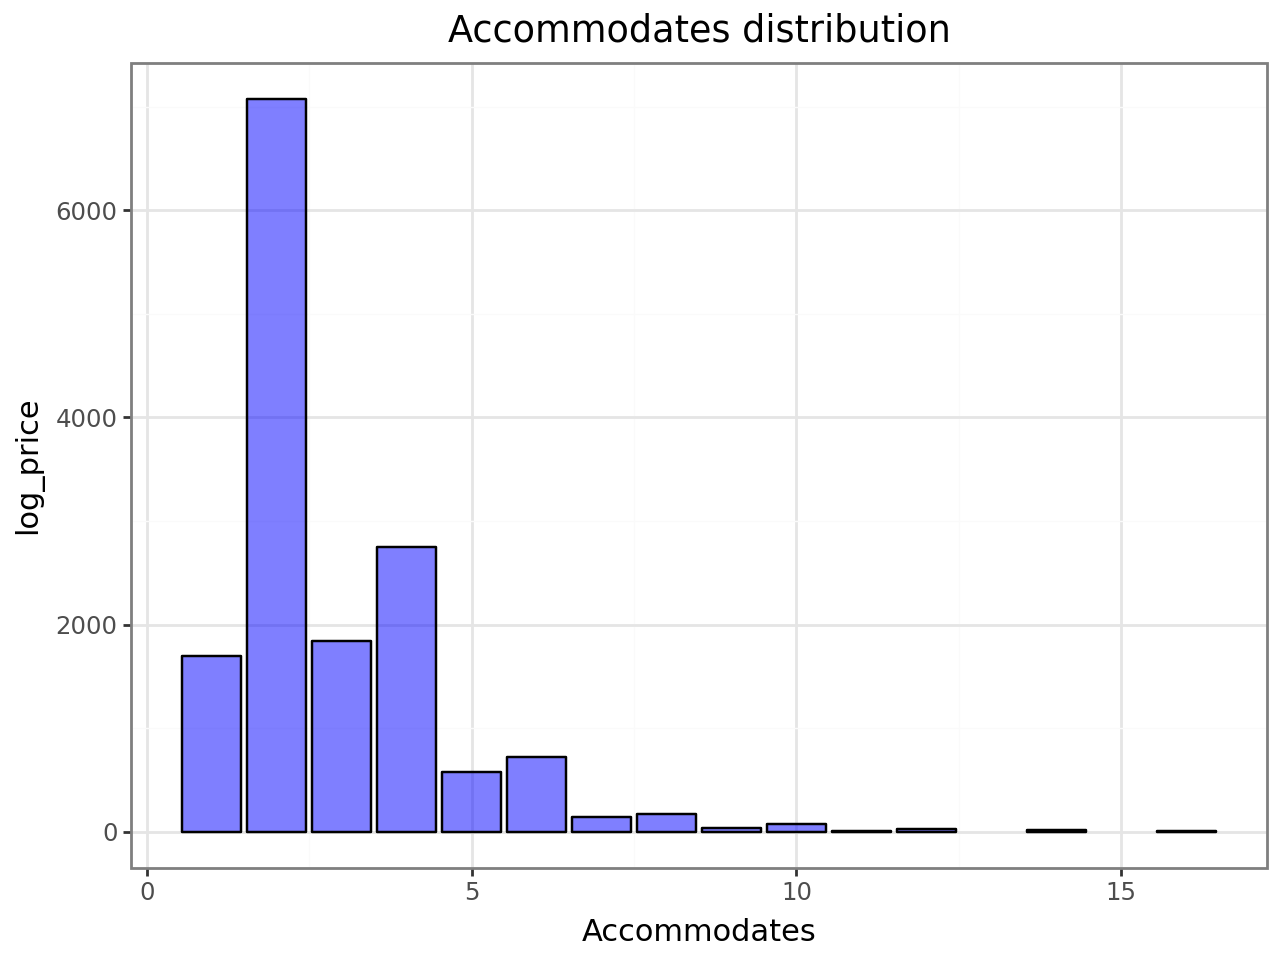

In [28]:
data_aggregated = data.groupby('accommodates', as_index=False)['log_price'].sum()

# Create a ggplot-style bar plot using geom_col()
plot = (
    ggplot(data_aggregated, aes(x = "accommodates", y = "log_price"))
    + geom_col(fill = "blue", color = "black", alpha = 0.5)
    + labs(x = "Accommodates", y = "log_price", title = "Accommodates distribution")
    + theme_bw()
)

plot

## Regressions

In [19]:
import statsmodels.formula.api as smf

In [20]:
reg = smf.ols(formula = "log_price ~ longitude", data = data).fit(cov_type="HC1")
reg.summary()

with open("regression_summary.tex", "w") as f:
    f.write(reg.summary().as_latex())

In [21]:
# to simplify regression results interpretation let's modify longtitude values by multiplication (*100) to get a change 
# of 1 step instead of 0.01 steps

data["longitude"] = data["longitude"] * 100
data["squared_longitude"] = data["longitude"] ** 2

In [75]:
# range of longitude [11.39; 11.71]
# we have to take into account that out regression table depicts 
reg2 = smf.ols(formula = "log_price ~ longitude + squared_longitude", data = data).fit(cov_type="HC1")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     30.42
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           8.22e-14
Time:                        12:21:39   Log-Likelihood:                -3277.4
No. Observations:                3115   AIC:                             6561.
Df Residuals:                    3112   BIC:                             6579.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3259.0321    418.659     -7.784      0.000   -4079.588   -2438.476
longitude             5.6429      0.724      7.795      0.000       4.224       7.062
squared_longitude    -0.0024      0.000     -7.794      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      223.639   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.486
Skew:                           0.629   Prob(JB):                     2.52e-65
Kurtosis:                       3.843   Cond. No.                     4.32e+10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.32e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
z = reg2.get_prediction().conf_int()
res = reg2.get_prediction().summary_frame()
data["lnwpred_longq"] = res["mean"]
data["lnwpred_longqCIUP"] = [x[0] for x in z]
data["lnwpred_longqCILO"] = [x[1] for x in z]

In [81]:
results_data = pd.DataFrame({
    'fitted_values': reg2.fittedvalues,  
    'residuals': reg2.resid 
})

In [ ]:
data = data.join(results_data[['fitted_values', 'residuals']])

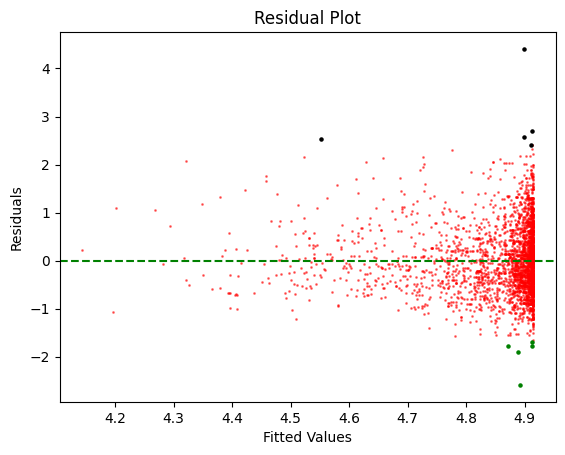

In [118]:
residuals = reg2.resid
largest_positive_errors = data.nlargest(5, 'residuals')
largest_negative_errors = data.nsmallest(5, 'residuals')

plt.scatter(reg2.fittedvalues, reg2.resid, alpha=0.5, s = 1, color='red')
plt.scatter(
    largest_positive_errors['fitted_values'], largest_positive_errors['residuals'], 
    color='black', s=5, label='Largest Positive Errors'
)
plt.scatter(
    largest_negative_errors['fitted_values'], largest_negative_errors['residuals'], 
    color='green', s=5, label='Largest Negative Errors'
)
plt.axhline(0, color='green', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.savefig('residual_plot.jpg')
plt.show()

In [92]:
largest_positive_errors

,id,price,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,availability_365,number_of_reviews,...,lnwpred_ageqCILO,lnwpred_priceq,lnwpred_priceqCIUP,lnwpred_priceqCILO,lnwpred_longq,lnwpred_longqCIUP,lnwpred_longqCILO,fitted_values,residuals,check
1221,2.596173e+07,11000,0,48.210610,1154.259000,Entire rental unit,Entire home/apt,4,173,10,...,4.927763,4.898153,4.868544,4.927763,4.898153,4.868544,4.927763,4.898153,4.407497,9.305651
3284,6.630000e+17,2000,0,48.151280,1155.886420,Entire condo,Entire home/apt,5,306,11,...,4.940771,4.912182,4.883594,4.940771,4.912182,4.883594,4.940771,4.912182,2.688720,7.600902
5752,1.050000e+18,1750,0,48.129314,1154.366550,Entire condo,Entire home/apt,10,53,0,...,4.928982,4.899479,4.869977,4.928982,4.899479,4.869977,4.928982,4.899479,2.567892,7.467371
6378,1.160000e+18,1203,0,48.104870,1169.032096,Entire home,Entire home/apt,6,266,0,...,4.654276,4.551859,4.449442,4.654276,4.551859,4.449442,4.654276,4.551859,2.540715,7.092574
5002,9.600000e+17,1500,0,48.130267,1155.682571,Entire loft,Entire home/apt,7,348,1,...,4.939794,4.911133,4.882472,4.939794,4.911133,4.882472,4.939794,4.911133,2.402088,7.313220


In [95]:
largest_negative_errors

,id,price,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,availability_365,number_of_reviews,...,lnwpred_ageqCILO,lnwpred_priceq,lnwpred_priceqCIUP,lnwpred_priceqCILO,lnwpred_longq,lnwpred_longqCIUP,lnwpred_longqCILO,fitted_values,residuals,check
4910,9.520000e+17,10,0,48.164222,1153.745170,Private room in condo,Private room,4,24,4,...,4.921267,4.891041,4.860814,4.921267,4.891041,4.860814,4.921267,4.891041,-2.588456,2.302585
5984,1.100000e+18,20,0,48.169080,1160.111000,Private room in camper/rv,Private room,1,252,8,...,4.918493,4.888304,4.858114,4.918493,4.888304,4.858114,4.918493,4.888304,-1.892572,2.995732
279,3.219673e+06,22,0,48.173700,1152.602000,Private room in rental unit,Private room,1,244,61,...,4.903015,4.870596,4.838178,4.903015,4.870596,4.838178,4.903015,4.870596,-1.779554,3.091042
1317,2.799733e+07,23,0,48.181560,1157.760000,Private room in rental unit,Private room,2,20,7,...,4.940746,4.912335,4.883924,4.940746,4.912335,4.883924,4.940746,4.912335,-1.776841,3.135494
5230,9.730000e+17,25,0,48.169316,1157.854754,Private room in rental unit,Private room,2,116,0,...,4.940315,4.911888,4.883461,4.940315,4.911888,4.883461,4.940315,4.911888,-1.693012,3.218876


In [89]:
plotdata = data.filter(["longitude", "lnwpred_longq", "lnwpred_longqCIUP", "lnwpred_longqCILO"]).melt(
    id_vars=["longitude"]
)
plotdata

,longitude,variable,value
0,1148.954000,lnwpred_longq,4.762728
1,1163.758000,lnwpred_longq,4.797675
2,1146.586000,lnwpred_longq,4.657964
3,1152.733000,lnwpred_longq,4.873263
4,1155.507000,lnwpred_longq,4.910066
...,...,...,...
9340,1157.178158,lnwpred_longqCILO,4.942493
9341,1155.685842,lnwpred_longqCILO,4.939811
9342,1151.799000,lnwpred_longqCILO,4.887261
9343,1155.608640,lnwpred_longqCILO,4.939393


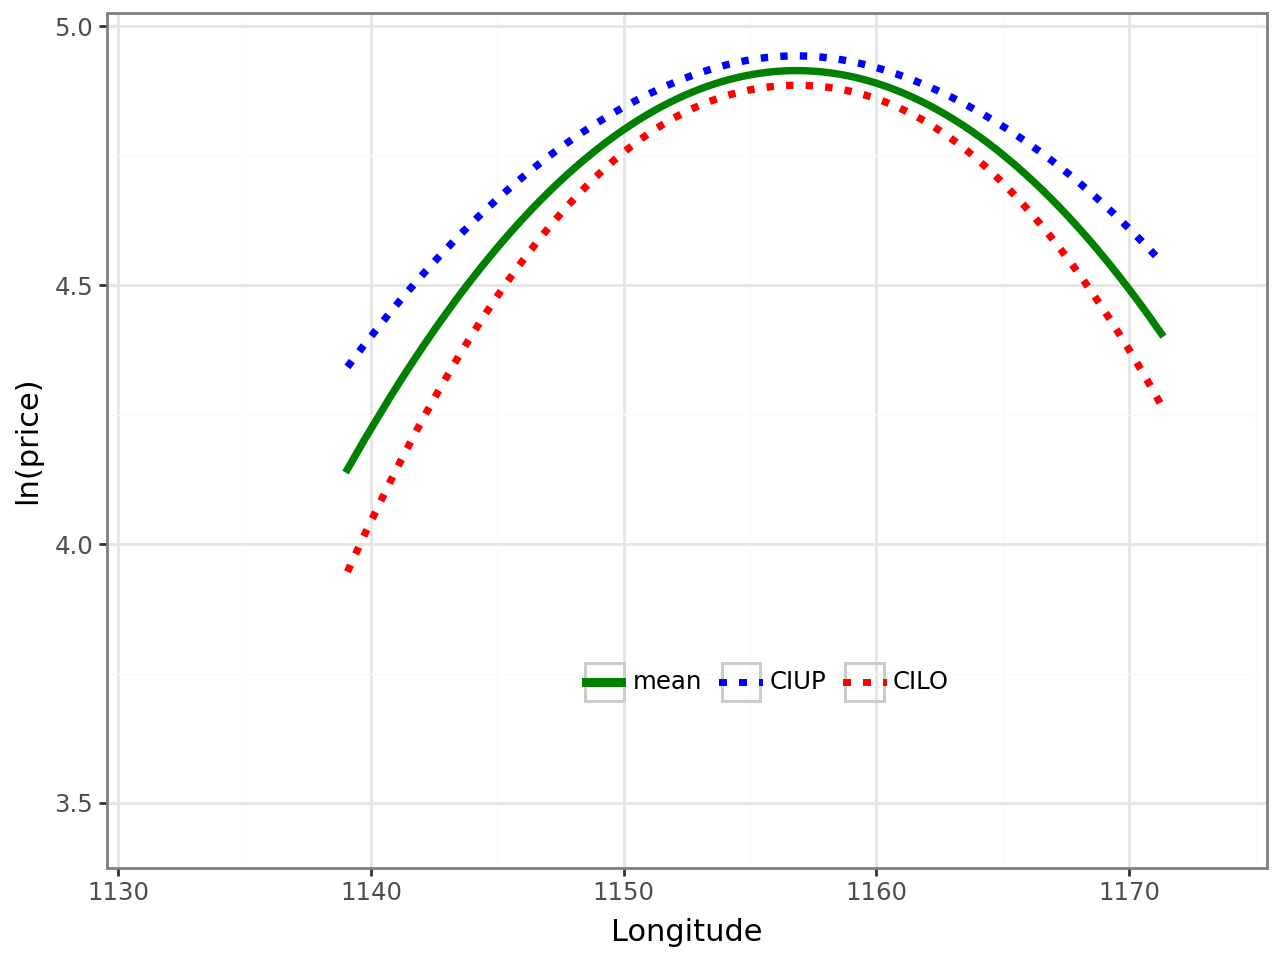

In [36]:
(
    ggplot(
        plotdata,
        aes(x="longitude", y="value", color="variable", linetype="variable"),
    )
    + geom_line(size=1.5)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1130, 1175))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(3.4, 5)
    )
    + scale_color_manual(
        values=['green', 'blue', 'red'],
        labels=["mean", "CIUP", "CILO"],
    )
    + scale_linetype_manual(
        values=["-", ":", ":"],
        labels=["mean", "CIUP", "CILO"],
    )
    + labs(x="Longitude", y="ln(price)")
    + theme_bw()
    + theme(
        legend_position=(0.6, 0.2),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
)

In [149]:
pred_confidence.describe()

,id,price,latitude,longitude,accommodates,availability_365,number_of_reviews,review_scores_rating,instant_bookable,log_price,squared_longitude,price_pred,lwr,upr,fit
count,3.115000e+03,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,2605.000000,3115.000000,3115.000000,3.115000e+03,3115.000000,1448.000000,1448.000000,3115.000000
mean,5.175201e+17,172.108828,48.139157,1156.467694,2.760835,143.216693,37.333868,4.817159,0.140931,4.855254,1.337442e+06,4.855254,4.817588,4.893079,4.855254
std,4.801601e+17,252.533133,0.026258,4.911217,1.584367,112.481188,89.655923,0.277073,0.348006,0.700444,1.135940e+04,0.101457,0.123230,0.082390,0.101457
min,9.794500e+04,10.000000,48.072350,1139.070000,1.000000,0.000000,0.000000,1.000000,0.000000,2.302585,1.297480e+06,4.144262,3.946459,4.342065,4.144262
25%,2.859023e+07,79.000000,48.121081,1153.832605,2.000000,43.500000,2.000000,4.740000,0.000000,4.369448,1.331330e+06,4.847510,4.814420,4.885193,4.847510
50%,6.780000e+17,120.000000,48.136620,1156.502000,2.000000,113.000000,8.000000,4.900000,0.000000,4.787492,1.337497e+06,4.898479,4.868835,4.927803,4.898479
75%,9.710000e+17,195.000000,48.156370,1158.750000,4.000000,236.000000,31.000000,5.000000,0.000000,5.273000,1.342702e+06,4.911852,4.883380,4.940393,4.911852
max,1.190000e+18,11000.000000,48.224071,1171.269892,16.000000,365.000000,1412.000000,5.000000,1.000000,9.305651,1.371873e+06,4.914400,4.886010,4.942791,4.914400


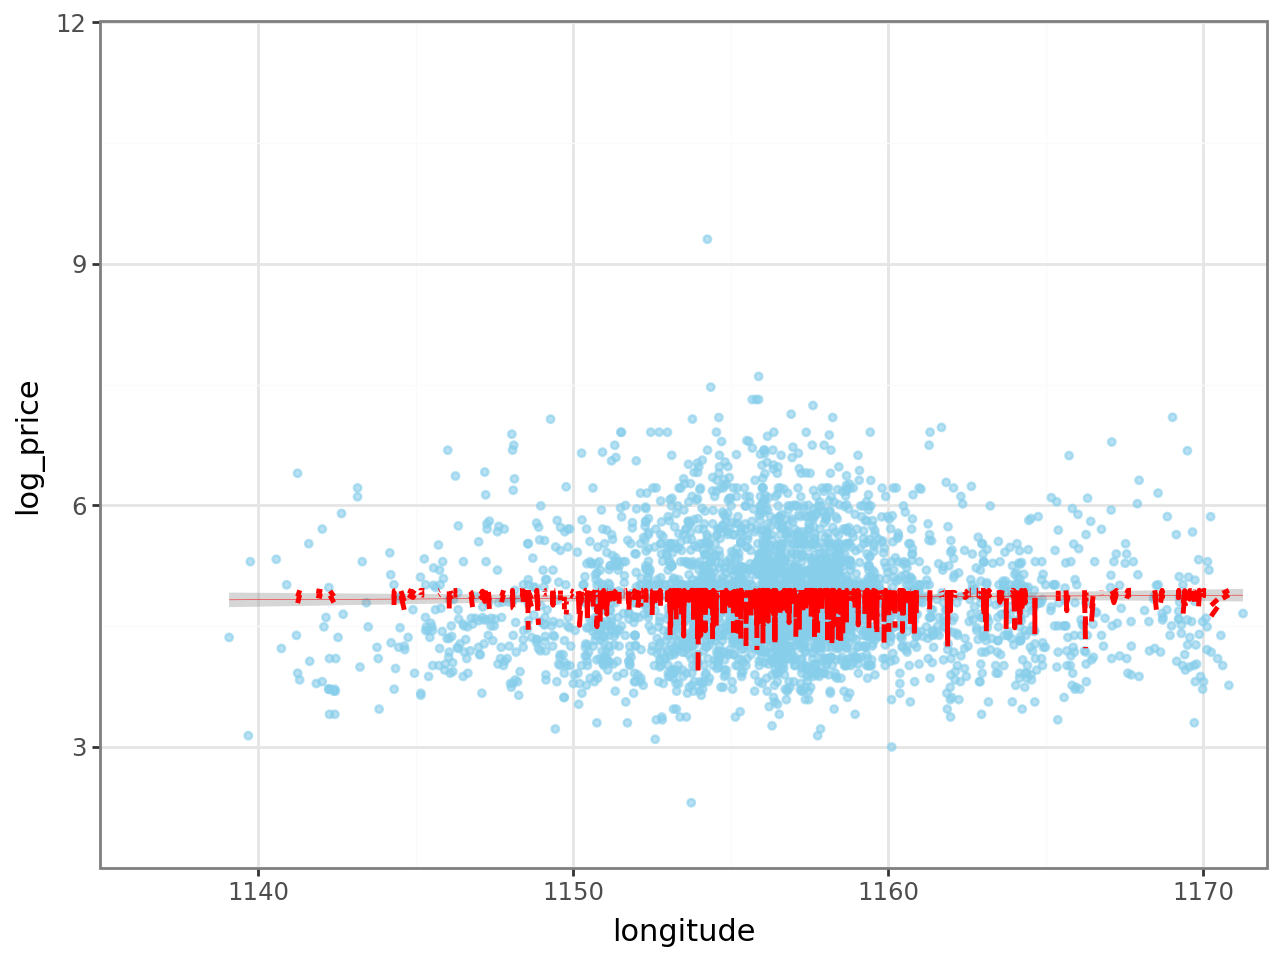

In [134]:
(
    ggplot(
        pred_confidence.loc[lambda x: (x["log_price"] < 11) & (x["log_price"] > 2)],
        aes(x="longitude", y="log_price"),
    )
    + geom_point(color='skyblue', size=1, alpha=0.6, show_legend = False, na_rm=True)
    + geom_smooth(method="lm", colour='red', se=True, size=0.1, linetype="solid")
    + geom_line(
        pred_confidence,
        aes(x="longitude", y="lwr"),
        size=1,
        linetype="dashed",
        colour='red',
    )
    + geom_line(
        pred_confidence,
        aes(x="longitude", y="upr"),
        size = 1,
        linetype="dashed",
        colour='red',
    )
    + coord_cartesian(xlim=(1135, 1172), ylim=(1.5, 12))
    + scale_x_continuous(expand=(0.001, 0.001), limits=(1135, 1200))#, breaks=seq(20, 65, by=5))
    + scale_y_continuous(
        expand=(0.001, 0.001), limits=(1.5, 10)#, breaks=seq(1.5, 4.5, by=0.50)
    )
    + labs(x="longitude", y="log_price")
    + scale_linetype_manual(
        name="",
        values=(1, 1, 2),
        labels=("Lowess", "Confidence interval (95%)", "Confidence interval (95%)"),
    )
    + theme_bw()
)


In [82]:
data.describe()

,id,price,latitude,longitude,accommodates,availability_365,number_of_reviews,review_scores_rating,instant_bookable,log_price,squared_longitude
count,3.115000e+03,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,2605.000000,3115.000000,3115.000000,3.115000e+03
mean,5.175201e+17,172.108828,48.139157,11.564677,2.760835,143.216693,37.333868,4.817159,0.140931,4.855254,1.337442e+06
std,4.801601e+17,252.533133,0.026258,0.049112,1.584367,112.481188,89.655923,0.277073,0.348006,0.700444,1.135940e+04
min,9.794500e+04,10.000000,48.072350,11.390700,1.000000,0.000000,0.000000,1.000000,0.000000,2.302585,1.297480e+06
25%,2.859023e+07,79.000000,48.121081,11.538326,2.000000,43.500000,2.000000,4.740000,0.000000,4.369448,1.331330e+06
50%,6.780000e+17,120.000000,48.136620,11.565020,2.000000,113.000000,8.000000,4.900000,0.000000,4.787492,1.337497e+06
75%,9.710000e+17,195.000000,48.156370,11.587500,4.000000,236.000000,31.000000,5.000000,0.000000,5.273000,1.342702e+06
max,1.190000e+18,11000.000000,48.224071,11.712699,16.000000,365.000000,1412.000000,5.000000,1.000000,9.305651,1.371873e+06


In [87]:
import math
def measure(lat1, lon1, lat2, lon2):
    # Radius of Earth in KM
    R = 6378.137 
    
    # Convert degrees to radians
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    
    # Haversine formula
    a = math.sin(dLat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dLon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Calculate distance in kilometers
    d = R * c
    
    # Return distance in meters
    return d * 1000  # meters

In [89]:
distance = measure(48.072350, 11.390700, 48.224071, 11.712699)
distance

29278.328141311627

In [90]:
room_types = ["Entire home/apt", "Private room"]

In [93]:
models = []
for room_type in room_types:
    models.append(
        smf.ols(
            "log_price ~ longitude + squared_longitude", data=data.loc[lambda x: x["room_type"] == room_type]
        ).fit(cov_type="HC1")
    )

In [96]:
stargazer = Stargazer(models)
stargazer.custom_columns(room_types, [1, 1])
stargazer.show_model_numbers(False)
HTML(stargazer.render_html())
latex_output = stargazer.render_latex()
with open("stargazert.tex", "w") as file:
    file.write(latex_output)

In [36]:

data = data.dropna()
data["rating"] = np.where(
    data["review_scores_rating"] <= 4, "<= 4",
    np.where((data["review_scores_rating"] > 4) & (data["review_scores_rating"] <= 4.5), "(4, 4.5]",
    np.where((data["review_scores_rating"] > 4.5) & (data["review_scores_rating"] <= 4.75), "(4.5, 4.75]",
    np.where((data["review_scores_rating"] > 4.75) & (data["review_scores_rating"] <= 4.85), "(4.75, 4.85]",
    np.where((data["review_scores_rating"] > 4.85) & (data["review_scores_rating"] <= 5), "> 4.85", data["review_scores_rating"])))))

In [37]:
ratings = ["<= 4", "(4, 4.5]", "(4.5, 4.75]", "(4.75, 4.85]", "> 4.85"]

models = []
for rating in ratings:
    models.append(
        smf.ols(
            "log_price ~ longitude + squared_longitude", data = data.loc[lambda x: x["rating"] == rating]
        ).fit(cov_type="HC1")
    )

In [38]:
stargazer = Stargazer(models)
stargazer.custom_columns(ratings, [1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
HTML(stargazer.render_html())